# Transformer Architecture: A Practical Introduction

This notebook provides a pedagogical introduction to transformer architectures. We'll build a small transformer from scratch to understand the core components, then implement a simple example.

## 1. Setup and Dependencies

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Understanding Transformer Architecture

The transformer architecture, introduced in the "Attention is All You Need" paper (Vaswani et al., 2017), revolutionized NLP by eliminating recurrence and convolutions while focusing on attention mechanisms.

Key components of a transformer include:
1. **Self-Attention**: Allows the model to weigh the importance of different words in relation to each other
2. **Multi-Head Attention**: Multiple attention mechanisms in parallel
3. **Positional Encoding**: Provides information about token positions
4. **Feed-Forward Networks**: Process attended information
5. **Layer Normalization**: Stabilizes learning
6. **Residual Connections**: Help with gradient flow

Let's implement these components from scratch to gain a deeper understanding.

## 3. Building Transformer Components

### 3.1 Positional Encoding

Unlike RNNs, transformers process all tokens simultaneously, so they need positional encoding to understand sequence order.

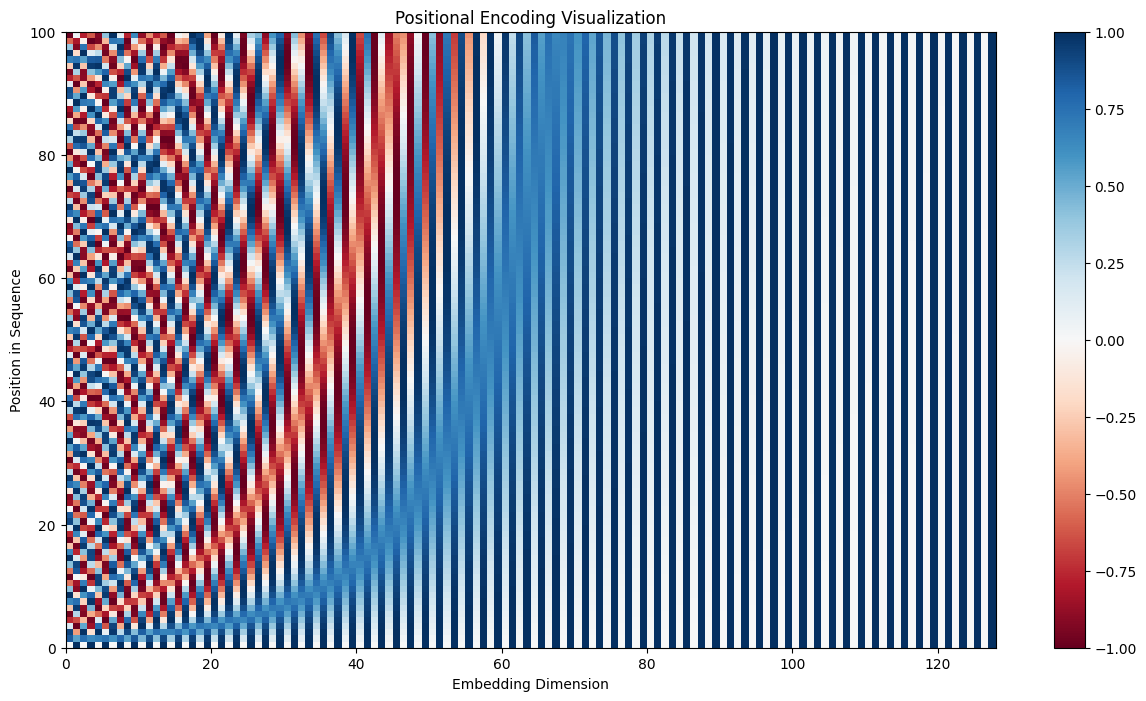

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension
        pe = pe.unsqueeze(0)
        
        # Register buffer (persistent state that's not a parameter)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to the input
        # x shape: [batch_size, seq_length, d_model]
        return x + self.pe[:, :x.size(1)]

# Visualize positional encodings
d_model = 128
max_seq_len = 100
pos_encoder = PositionalEncoding(d_model, max_seq_len)
pe = pos_encoder.pe.squeeze(0).numpy()

plt.figure(figsize=(15, 8))
plt.pcolormesh(pe, cmap='RdBu')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.colorbar()
plt.title('Positional Encoding Visualization')
plt.show()

### 3.2 Self-Attention Mechanism

The core of transformer architecture is the self-attention mechanism. It allows the model to focus on different parts of the input sequence when processing each token.

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, mask=None):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.scale = math.sqrt(d_model)
        self.mask = mask
        
        # Query, Key, and Value projections
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]
        batch_size, seq_length, d_model = x.size()
        
        # Create Q, K, V projections
        q = self.q_linear(x)  # [batch_size, seq_length, d_model]
        k = self.k_linear(x)  # [batch_size, seq_length, d_model]
        v = self.v_linear(x)  # [batch_size, seq_length, d_model]
        
        # Calculate attention scores
        # (batch_size, seq_length, d_model) x (batch_size, d_model, seq_length)
        # -> (batch_size, seq_length, seq_length)
        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        
        # Apply mask if provided (for decoder self-attention)
        if self.mask is not None:
            scores = scores.masked_fill(self.mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        
        # Apply attention weights to values
        # (batch_size, seq_length, seq_length) x (batch_size, seq_length, d_model)
        # -> (batch_size, seq_length, d_model)
        output = torch.matmul(attention_weights, v)
        
        return output, attention_weights

### 3.3 Multi-Head Attention

Multi-head attention allows the model to jointly attend to information from different representation subspaces, improving the model's ability to capture diverse relationships.

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, mask=None):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension of each head
        self.mask = mask
        
        # Linear projections for Q, K, V, and output
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)
        
    def split_heads(self, x):
        # Split the last dimension into (num_heads, d_k)
        # x shape: [batch_size, seq_length, d_model]
        batch_size, seq_length, d_model = x.size()
        
        # Reshape to [batch_size, seq_length, num_heads, d_k]
        x = x.view(batch_size, seq_length, self.num_heads, self.d_k)
        
        # Transpose to [batch_size, num_heads, seq_length, d_k]
        return x.transpose(1, 2)
    
    def forward(self, x):
        batch_size, seq_length, d_model = x.size()
        
        # Linear projections
        q = self.q_linear(x)  # [batch_size, seq_length, d_model]
        k = self.k_linear(x)  # [batch_size, seq_length, d_model]
        v = self.v_linear(x)  # [batch_size, seq_length, d_model]
        
        # Split into multiple heads
        q = self.split_heads(q)  # [batch_size, num_heads, seq_length, d_k]
        k = self.split_heads(k)  # [batch_size, num_heads, seq_length, d_k]
        v = self.split_heads(v)  # [batch_size, num_heads, seq_length, d_k]
        
        # Calculate attention scores
        scale = math.sqrt(self.d_k)
        scores = torch.matmul(q, k.transpose(-2, -1)) / scale  # [batch_size, num_heads, seq_length, seq_length]
        
        # Apply mask if provided
        if self.mask is not None:
            scores = scores.masked_fill(self.mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        
        # Apply attention weights to values
        context = torch.matmul(attention_weights, v)  # [batch_size, num_heads, seq_length, d_k]
        
        # Transpose and reshape back
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, d_model)
        
        # Final linear projection
        output = self.out_linear(context)
        
        return output, attention_weights

### 3.4 Feed-Forward Network

Each transformer layer contains a feed-forward network that processes the attended information.

In [5]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        # First linear layer with ReLU activation
        x = F.relu(self.linear1(x))
        # Dropout for regularization
        x = self.dropout(x)
        # Second linear layer
        x = self.linear2(x)
        return x

### 3.5 Transformer Encoder Layer

Now let's combine these components to create a complete transformer encoder layer.

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        
        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Multi-head attention with residual connection and layer normalization
        attn_output, _ = self.attention(x)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward network with residual connection and layer normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

### 3.6 Complete Transformer Encoder

Now let's stack multiple encoder layers to create a complete transformer encoder.

In [7]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_length, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        
        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Stack of encoder layers
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) 
                                     for _ in range(num_layers)])
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x):
        # Convert input tokens to embeddings
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Pass through each encoder layer
        for layer in self.layers:
            x = layer(x)
        
        # Apply final layer normalization
        x = self.norm(x)
        
        return x

## 4. Practical Example: Sequence Classification

Let's implement a simple sequence classification model using our transformer encoder. We'll create a synthetic dataset for demonstration.

In [8]:
# Define a sequence classification model
class SequenceClassifier(nn.Module):
    def __init__(self, encoder, d_model, num_classes):
        super(SequenceClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        # Get encoder output
        encoder_output = self.encoder(x)  # [batch_size, seq_length, d_model]
        
        # Use the representation of the [CLS] token (first token) for classification
        cls_representation = encoder_output[:, 0, :]  # [batch_size, d_model]
        
        # Apply the classifier
        logits = self.classifier(cls_representation)  # [batch_size, num_classes]
        
        return logits

### 4.1 Create a Synthetic Dataset

Let's create a simple synthetic dataset for demonstration.

In [9]:
# Create a synthetic dataset
def generate_synthetic_data(num_samples=1000, max_seq_length=20, vocab_size=1000, num_classes=2):
    # Generate random sequences
    X = np.random.randint(1, vocab_size, size=(num_samples, max_seq_length))
    
    # Add special [CLS] token at the beginning (token ID = 0)
    X[:, 0] = 0
    
    # Generate random labels
    y = np.random.randint(0, num_classes, size=num_samples)
    
    # Convert to PyTorch tensors
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    
    return X, y

# Generate data
vocab_size = 1000
d_model = 128
num_heads = 8
d_ff = 512
num_layers = 2
max_seq_length = 20
num_classes = 2

X_train, y_train = generate_synthetic_data(num_samples=800, max_seq_length=max_seq_length, 
                                          vocab_size=vocab_size, num_classes=num_classes)
X_val, y_val = generate_synthetic_data(num_samples=200, max_seq_length=max_seq_length, 
                                      vocab_size=vocab_size, num_classes=num_classes)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")

Training data shape: torch.Size([800, 20]), torch.Size([800])
Validation data shape: torch.Size([200, 20]), torch.Size([200])


### 4.2 Create DataLoader

In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Create DataLoader
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### 4.3 Initialize and Train the Model

In [11]:
# Initialize the model
encoder = TransformerEncoder(vocab_size=vocab_size, d_model=d_model, num_heads=num_heads,
                            d_ff=d_ff, num_layers=num_layers, max_seq_length=max_seq_length)
model = SequenceClassifier(encoder, d_model=d_model, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    # Calculate epoch metrics
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100.0 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track metrics
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    # Calculate epoch metrics
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/5: Train Loss: 0.7332, Train Acc: 51.88%, Val Loss: 0.6948, Val Acc: 49.50%
Epoch 2/5: Train Loss: 0.6867, Train Acc: 55.38%, Val Loss: 0.6989, Val Acc: 55.50%
Epoch 3/5: Train Loss: 0.6937, Train Acc: 54.00%, Val Loss: 0.7586, Val Acc: 46.00%
Epoch 4/5: Train Loss: 0.6535, Train Acc: 61.75%, Val Loss: 0.9540, Val Acc: 43.50%
Epoch 5/5: Train Loss: 0.5905, Train Acc: 67.38%, Val Loss: 0.8438, Val Acc: 53.00%


### 4.4 Visualize Training Progress

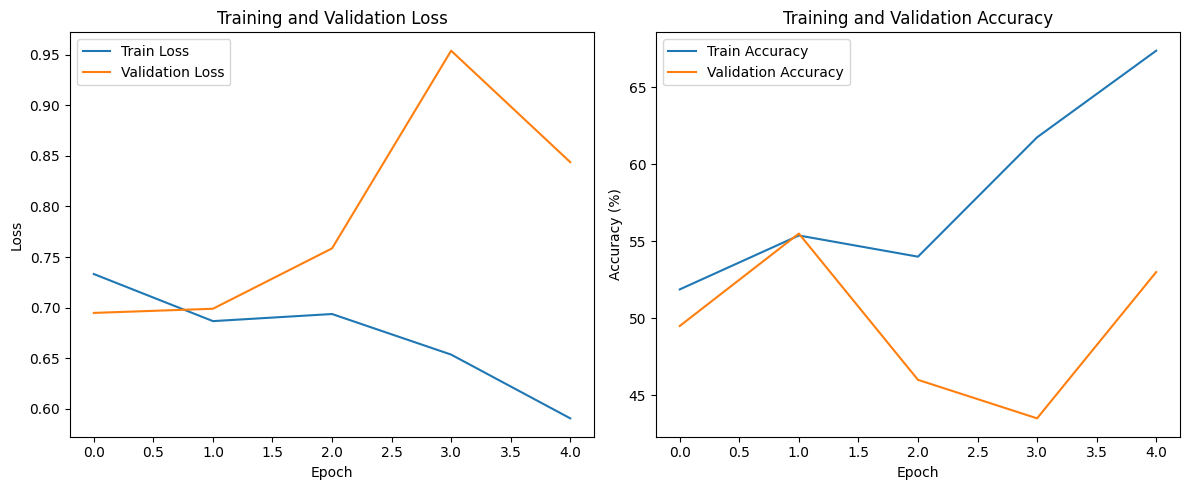

In [12]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## 5. Visualizing Attention Patterns

One of the advantages of transformers is that we can visualize the attention patterns to understand what the model is focusing on.

In [13]:
# Modify the encoder layer to return attention weights
class EncoderLayerWithAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayerWithAttention, self).__init__()
        
        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, num_heads)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Multi-head attention with residual connection and layer normalization
        attn_output, attention_weights = self.attention(x)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward network with residual connection and layer normalization
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attention_weights

# Create a new encoder that returns attention weights
class TransformerEncoderWithAttention(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_length, dropout=0.1):
        super(TransformerEncoderWithAttention, self).__init__()
        
        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Stack of encoder layers
        self.layers = nn.ModuleList([EncoderLayerWithAttention(d_model, num_heads, d_ff, dropout) 
                                     for _ in range(num_layers)])
        
        # Layer normalization
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x):
        # Convert input tokens to embeddings
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Store attention weights from each layer
        attention_weights = []
        
        # Pass through each encoder layer
        for layer in self.layers:
            x, attn_weights = layer(x)
            attention_weights.append(attn_weights)
        
        # Apply final layer normalization
        x = self.norm(x)
        
        return x, attention_weights

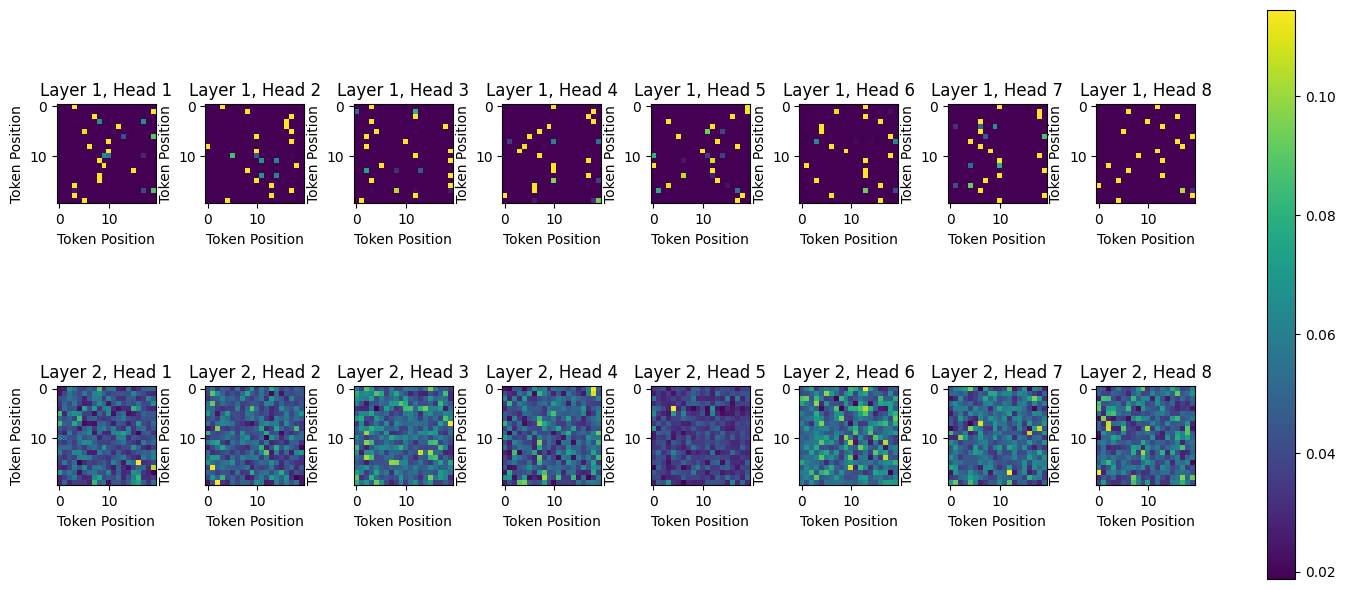

In [14]:
# Initialize the model with attention visualization
encoder_with_attn = TransformerEncoderWithAttention(vocab_size=vocab_size, d_model=d_model, 
                                                    num_heads=num_heads, d_ff=d_ff, 
                                                    num_layers=num_layers, 
                                                    max_seq_length=max_seq_length)

# Function to visualize attention weights
def visualize_attention(model, input_seq):
    model.eval()
    with torch.no_grad():
        # Get encoder output and attention weights
        _, attention_weights = model(input_seq)
        
        # Plot attention weights for each layer and head
        num_layers = len(attention_weights)
        num_heads = attention_weights[0].size(1)
        seq_length = attention_weights[0].size(2)
        
        # Create a grid of plots
        fig, axs = plt.subplots(num_layers, num_heads, figsize=(15, 3 * num_layers))
        
        for layer in range(num_layers):
            for head in range(num_heads):
                # Get attention weights for this layer and head
                attn = attention_weights[layer][0, head].cpu().numpy()
                
                # Plot as a heatmap
                if num_layers > 1:
                    ax = axs[layer, head]
                else:
                    ax = axs[head]
                    
                im = ax.imshow(attn, cmap='viridis')
                ax.set_title(f'Layer {layer+1}, Head {head+1}')
                ax.set_xlabel('Token Position')
                ax.set_ylabel('Token Position')
                
        plt.tight_layout()
        plt.colorbar(im, ax=axs.ravel().tolist())
        plt.show()

# Visualize attention for a sample input
sample_input = X_val[:1]  # Take the first validation sample
visualize_attention(encoder_with_attn, sample_input)

## 6. Conclusion and Key Takeaways

In this notebook, we've built a transformer architecture from scratch and implemented a simple sequence classification task. Key takeaways include:

1. **Transformer Architecture**: We've seen how transformers use self-attention mechanisms to capture relationships between tokens in a sequence, regardless of their distance.

2. **Core Components**:
   - Self-Attention: Allows the model to weigh the importance of different tokens
   - Multi-Head Attention: Enables the model to attend to different representation subspaces
   - Positional Encoding: Adds position information to tokens
   - Feed-Forward Networks: Processes the attended information
   - Layer Normalization and Residual Connections: Stabilizes training

3. **Advantages of Transformers**:
   - Parallelizable computation (unlike RNNs)
   - Ability to capture long-range dependencies
   - Interpretable attention patterns
   - Scalable architecture

4. **Practical Applications**: Transformers have revolutionized NLP and are now being applied to various domains including computer vision, time-series analysis, and more.

This implementation provides a foundation for understanding transformer architectures. In practice, you would typically use optimized libraries like Hugging Face's Transformers for pre-trained models or PyTorch's built-in transformer modules for custom implementations.